<h1 align=center><font size = 4>IBM/Coursera Data Science Capstone Project</font></h1>
<h1 align=center><font size = 5>Segmenting and Clustering Airbnb Listings in Zurich, Switzerland</font></h1>

# Table of Contents

* [Introduction/Business Problem](#introduction)
* [Setup](#setup)
* [Data](#data)
* [Methodolody](#methodology)
    * [Data Wrangling: Clean and Transform](#data_wrangling)
    * [Explore and Visualize Airbnb Data](#airbnb_data_visualize)
    * [Analyze Each Airbnb Listing](#analysis)
    * [Prepare data for Machine Learning](#preparation)
    * [Cluster Airbnb Listings](#clustering)
* [Results](#results)
* [Discussion and Recommendations](#discussion)
* [Conclusion](#conclusion)

# Introduction/Business Problem <a name="introduction"></a>

[Airbnb](https://www.airbnb.com/) is a community where millions of hosts and travelers choose to create a free account, so they can list their space and book unique accommodations anywhere in the world.

Although Airbnb listings provide enough information about the shared space, there is less information about the nearby location. For example, travelers might be interested in what kind of venues (supermarkets, restaurants, public transportation, etc) are close to the accommodation they book. In addition, travelers cannot filter Airbnb listings based on the nearby venues. In other words, each time travelers make a search for an accommodation using the Airbnb community, they may want to get direct information about the venues in the area and a list of similar Airbnb listings with same venue categories nearby.

The main objective of this project is to explore, segment and cluster Airbnb listings in Zurich, Switzerland. I will use the [Foursquare API](https://developer.foursquare.com/) to explore the areas around the Airbnb listings in Zurich. I will use the explore function to get the most common venue categories for each Airbnb listing, and then use this feature together with the prices to group the listings into clusters. I will use the k-means clustering algorithm to complete this task. Finally, I will use the Folium library to visualize the listings in Zurich and their emerging clusters.

# Setup <a name="setup"></a>

Import a few common modules and ensure MatplotLib plots figures inline

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import seaborn as sns
sns.set(style="darkgrid")

%matplotlib inline
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

print('Libraries imported.')

Libraries imported.


# Data <a name="data"></a>

Based on the problem definition, I will leverage the data from the following data sources to solve the problem:

- [Airbnb Data Collection](http://tomslee.net/airbnb-data-collection-get-the-data): Here is the data provided for each Airbnb listing. Each link downloads a zip file of the data for a named city or region; in my case this is Zurich, Switzerland. The zip file holds one or more csv files. Each csv file represents a single “survey” or “scrape” of the Airbnb web site for that city. The data is collected from the public Airbnb web site and the code used is available on [GitHub](https://github.com/tomslee/airbnb-data-collection). Each csv file contains the attributes as follows:
    * room_id: A unique number identifying an Airbnb listing.
    * host_id: A unique number identifying an Airbnb host.
    * room_type: One of “Entire home/apt”, “Private room”, or “Shared room”
    * borough: A sub-region of the city or search area for which the survey is carried out. The borough is taken from a shapefile of the city that is obtained independently of the Airbnb web site. For some cities, there is no borough information; for others the borough may be a number.
    * neighborhood: As with borough: a sub-region of the city or search area for which the survey is carried out. For cities that have both, a neighborhood is smaller than a borough. For some cities there is no neighborhood information.
    * reviews: The number of reviews that a listing has received. Airbnb has said that 70% of visits end up with a review, so the number of reviews can be used to estimate the number of visits. Note that such an estimate will not be reliable for an individual listing (especially as reviews occasionally vanish from the site), but over a city as a whole it should be a useful metric of traffic.
    * overall_satisfaction: The average rating (out of five) that the listing has received from those visitors who left a review.
    * accommodates: The number of guests a listing can accommodate.
    * bedrooms: The number of bedrooms a listing offers.
    * price: The price for a night stay. In early surveys, there may be some values that were recorded by month.
    * minstay: The minimum stay for a visit, as posted by the host.
    * latitude and longitude: The latitude and longitude of the listing as posted on the Airbnb site: this may be off by a few hundred meters.
    * last_modified: the date and time that the values were read from the Airbnb web site.


- [Foursquare API](https://developer.foursquare.com/): to get the most common venues of given Airbnb listing.

Airbnb data is used to get the coordinates (latitude and longitude), neighborhood and price for each listing in Zurich, Switzerland. Having this information, I can leverage Foursquare API to explore the areas around the Airbnb listings and get the most common venue categories for each listing. Venue categories together with the price are used to segment the listings into similar clusters.

### Get Airbnb Data <a name="get_airbnb_data"></a>

In [2]:
from zipfile import ZipFile
from io import BytesIO
from urllib.request import urlopen
from lxml.html import parse

URL = 'https://s3.amazonaws.com/tomslee-airbnb-data-2/zurich.zip'

zf = ZipFile(BytesIO(urlopen(URL).read()))
zf_names = [item for item in zf.namelist()]

zip_data = {text_file.filename: pd.read_csv(zf.open(text_file.filename)) for text_file in zf.infolist() if text_file.filename.endswith('.csv')}

airbnb_data = pd.concat(zip_data, ignore_index=True).dropna(axis=1, how='all')

### Take a Quick Look at the Data Structure

In [3]:
airbnb_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7985 entries, 0 to 7984
Data columns (total 19 columns):
room_id                 7985 non-null int64
survey_id               7985 non-null int64
host_id                 7985 non-null int64
room_type               7985 non-null object
country                 912 non-null object
city                    7985 non-null object
neighborhood            7985 non-null object
reviews                 7985 non-null int64
overall_satisfaction    6580 non-null float64
accommodates            7909 non-null float64
bedrooms                7984 non-null float64
bathrooms               817 non-null float64
price                   7985 non-null float64
minstay                 902 non-null float64
name                    7052 non-null object
last_modified           7985 non-null object
latitude                7985 non-null float64
longitude               7985 non-null float64
location                7985 non-null object
dtypes: float64(8), int64(4), object(

In [4]:
print(airbnb_data.shape)
airbnb_data.head()

(7985, 19)


,room_id,survey_id,host_id,room_type,country,city,neighborhood,reviews,overall_satisfaction,accommodates,bedrooms,bathrooms,price,minstay,name,last_modified,latitude,longitude,location
0,10130721,279,5582853,Private room,Switzerland,Zurich,Kreis 3,0,NaN,2.0,1.0,1.0,55.0,1.0,NaN,2016-01-11 08:07:01.722407,47.369338,8.511274,0101000020E61000001897AAB4C5052140C495B37746AF...
1,7497649,279,3572965,Entire home/apt,Switzerland,Zurich,Kreis 4,1,5.0,2.0,1.0,1.0,99.0,5.0,NaN,2016-01-11 08:06:57.678217,47.379176,8.516536,0101000020E6100000CF69166877082140CCB6D3D688B0...
2,9861242,279,50753703,Private room,Switzerland,Zurich,Kreis 11,2,5.0,1.0,1.0,1.0,36.0,1.0,NaN,2016-01-11 08:06:39.406766,47.418573,8.504743,0101000020E610000015C5ABAC6D0221408BFED0CC93B5...
3,8712997,279,28214726,Entire home/apt,Switzerland,Zurich,Kreis 10,1,4.0,2.0,0.0,1.0,83.0,2.0,NaN,2016-01-11 08:05:50.151073,47.402021,8.491612,0101000020E61000006EA46C91B4FB204011A7936C75B3...
4,946104,279,5126683,Private room,Switzerland,Zurich,Kreis 3,79,4.5,2.0,1.0,1.0,72.0,2.0,NaN,2016-01-11 08:05:46.497675,47.363486,8.519787,0101000020E61000009CC58B85210A2140E54691B586AE...


# Methodology <a name="methodology"></a>

## Data Wrangling: Clean and Transform <a name="data_wrangling"></a>

In [5]:
airbnb_data.room_id.value_counts()[:5]

3815437    4
4537943    4
2868924    4
4796892    4
2868985    4
Name: room_id, dtype: int64

The airbnb dataset contains the same listing more than one with different last modified dates. We group the listings by **room_id** and keep the latest of the **last_modified**

In [6]:
def keep_last_modified(frame):
    frame['last_modified'] = pd.to_datetime(frame['last_modified'])
    result = frame.loc[frame.groupby(['room_id'])['last_modified'].idxmax()].reset_index(drop=True)
    return result

In [7]:
zurich_data = keep_last_modified(airbnb_data)

In [8]:
zurich_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3359 entries, 0 to 3358
Data columns (total 19 columns):
room_id                 3359 non-null int64
survey_id               3359 non-null int64
host_id                 3359 non-null int64
room_type               3359 non-null object
country                 383 non-null object
city                    3359 non-null object
neighborhood            3359 non-null object
reviews                 3359 non-null int64
overall_satisfaction    3075 non-null float64
accommodates            3329 non-null float64
bedrooms                3358 non-null float64
bathrooms               353 non-null float64
price                   3359 non-null float64
minstay                 382 non-null float64
name                    2965 non-null object
last_modified           3359 non-null datetime64[ns]
latitude                3359 non-null float64
longitude               3359 non-null float64
location                3359 non-null object
dtypes: datetime64[ns](1), fl

In [9]:
print('Are the room IDs unique? {}'.format(len(zurich_data.room_id.unique())==len(zurich_data)))

Are the room IDs unique? True


In [10]:
zurich_data.last_modified.dt.year.value_counts()

2017    2976
2016     383
Name: last_modified, dtype: int64

We will use only listings from 2016 to reduce the dataset for visualization reasons

In [11]:
zurich_data = zurich_data[zurich_data.last_modified.dt.year == 2016].reset_index(drop=True)
zurich_data.head()

,room_id,survey_id,host_id,room_type,country,city,neighborhood,reviews,overall_satisfaction,accommodates,bedrooms,bathrooms,price,minstay,name,last_modified,latitude,longitude,location
0,71315,279,364415,Entire home/apt,Switzerland,Zurich,Kreis 3,141,4.5,5.0,2.0,1.0,98.0,1.0,NaN,2016-01-11 08:54:26.437837,47.374082,8.516890,0101000020E610000046425BCEA5082140DA0242EBE1AF...
1,142372,279,691660,Private room,Switzerland,Zurich,Kreis 9,73,5.0,1.0,1.0,NaN,64.0,5.0,NaN,2016-01-11 07:57:36.704603,47.385312,8.500321,0101000020E61000000801F9122A002140D06053E751B1...
2,274109,279,1433577,Private room,Switzerland,Zurich,Kreis 11,2,5.0,2.0,1.0,1.0,52.0,10.0,NaN,2016-01-11 08:50:07.759120,47.409038,8.531491,0101000020E6100000973C9E961F1021401F69705B5BB4...
3,425996,279,1976724,Private room,Switzerland,Zurich,Kreis 3,72,4.5,2.0,1.0,1.0,82.0,2.0,NaN,2016-01-11 08:37:38.594064,47.376023,8.510156,0101000020E610000063B7CF2A330521409CC58B8521B0...
4,434784,279,1509492,Entire home/apt,Switzerland,Zurich,Kreis 3,14,4.5,2.0,1.0,1.0,113.0,3.0,NaN,2016-01-11 08:20:21.730796,47.373439,8.518441,0101000020E6100000A2CF471971092140850662D9CCAF...


In [12]:
zurich_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383 entries, 0 to 382
Data columns (total 19 columns):
room_id                 383 non-null int64
survey_id               383 non-null int64
host_id                 383 non-null int64
room_type               383 non-null object
country                 383 non-null object
city                    383 non-null object
neighborhood            383 non-null object
reviews                 383 non-null int64
overall_satisfaction    249 non-null float64
accommodates            353 non-null float64
bedrooms                382 non-null float64
bathrooms               353 non-null float64
price                   383 non-null float64
minstay                 382 non-null float64
name                    0 non-null object
last_modified           383 non-null datetime64[ns]
latitude                383 non-null float64
longitude               383 non-null float64
location                383 non-null object
dtypes: datetime64[ns](1), float64(8), int64(4), 

Remove empty column **name** from the dataframe

In [13]:
features_to_drop=['name']
zurich_data.drop(features_to_drop, axis=1, inplace=True)

In [14]:
zurich_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383 entries, 0 to 382
Data columns (total 18 columns):
room_id                 383 non-null int64
survey_id               383 non-null int64
host_id                 383 non-null int64
room_type               383 non-null object
country                 383 non-null object
city                    383 non-null object
neighborhood            383 non-null object
reviews                 383 non-null int64
overall_satisfaction    249 non-null float64
accommodates            353 non-null float64
bedrooms                382 non-null float64
bathrooms               353 non-null float64
price                   383 non-null float64
minstay                 382 non-null float64
last_modified           383 non-null datetime64[ns]
latitude                383 non-null float64
longitude               383 non-null float64
location                383 non-null object
dtypes: datetime64[ns](1), float64(8), int64(4), object(5)
memory usage: 53.9+ KB


Remove rows with `NaN`

In [15]:
zurich_data.dropna(axis=0, inplace=True)
zurich_data.reset_index(drop=True, inplace=True)
zurich_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 18 columns):
room_id                 207 non-null int64
survey_id               207 non-null int64
host_id                 207 non-null int64
room_type               207 non-null object
country                 207 non-null object
city                    207 non-null object
neighborhood            207 non-null object
reviews                 207 non-null int64
overall_satisfaction    207 non-null float64
accommodates            207 non-null float64
bedrooms                207 non-null float64
bathrooms               207 non-null float64
price                   207 non-null float64
minstay                 207 non-null float64
last_modified           207 non-null datetime64[ns]
latitude                207 non-null float64
longitude               207 non-null float64
location                207 non-null object
dtypes: datetime64[ns](1), float64(8), int64(4), object(5)
memory usage: 29.2+ KB


In [16]:
zurich_data.head()

,room_id,survey_id,host_id,room_type,country,city,neighborhood,reviews,overall_satisfaction,accommodates,bedrooms,bathrooms,price,minstay,last_modified,latitude,longitude,location
0,71315,279,364415,Entire home/apt,Switzerland,Zurich,Kreis 3,141,4.5,5.0,2.0,1.0,98.0,1.0,2016-01-11 08:54:26.437837,47.374082,8.516890,0101000020E610000046425BCEA5082140DA0242EBE1AF...
1,274109,279,1433577,Private room,Switzerland,Zurich,Kreis 11,2,5.0,2.0,1.0,1.0,52.0,10.0,2016-01-11 08:50:07.759120,47.409038,8.531491,0101000020E6100000973C9E961F1021401F69705B5BB4...
2,425996,279,1976724,Private room,Switzerland,Zurich,Kreis 3,72,4.5,2.0,1.0,1.0,82.0,2.0,2016-01-11 08:37:38.594064,47.376023,8.510156,0101000020E610000063B7CF2A330521409CC58B8521B0...
3,434784,279,1509492,Entire home/apt,Switzerland,Zurich,Kreis 3,14,4.5,2.0,1.0,1.0,113.0,3.0,2016-01-11 08:20:21.730796,47.373439,8.518441,0101000020E6100000A2CF471971092140850662D9CCAF...
4,478764,279,2371495,Private room,Switzerland,Zurich,Kreis 5,53,4.5,3.0,1.0,1.0,87.0,1.0,2016-01-11 07:34:41.012047,47.383378,8.528108,0101000020E61000000E83F92B640E2140C100C28712B1...


## Explore and Visualize Airbnb Data <a name="airbnb_data_visualize"></a>

In [17]:
zurich_data.neighborhood.value_counts()

Kreis 3     34
Kreis 4     31
Kreis 6     23
Kreis 11    22
Kreis 10    21
Kreis 5     17
Kreis 1     13
Kreis 9     11
Kreis 8     10
Kreis 2     10
Kreis 12     8
Kreis 7      7
Name: neighborhood, dtype: int64

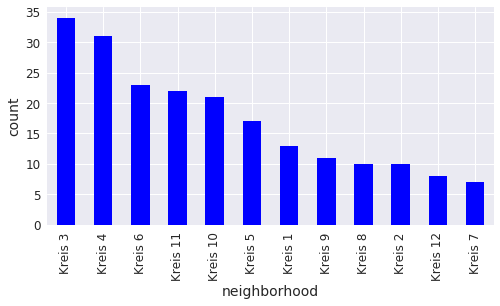

In [18]:
plt.figure(figsize=(8, 4))
zurich_data.neighborhood.value_counts().plot(kind='bar', color='b')
plt.xticks(rotation=90)
plt.ylabel('count')
plt.xlabel('neighborhood')
plt.show()

In [19]:
zurich_data.room_type.value_counts()

Private room       102
Entire home/apt     98
Shared room          7
Name: room_type, dtype: int64

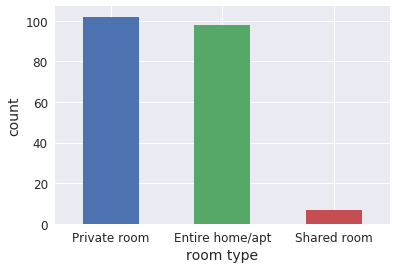

In [20]:
plt.figure(figsize=(6, 4))
zurich_data.room_type.value_counts().plot(kind='bar')
plt.xticks(rotation=0)
plt.ylabel('count')
plt.xlabel('room type')
plt.show()

Explore the **overall_satisfaction** and **price** attributes

In [21]:
zurich_data['overall_satisfaction'].value_counts()

5.0    107
4.5     74
4.0     20
3.0      3
3.5      3
Name: overall_satisfaction, dtype: int64

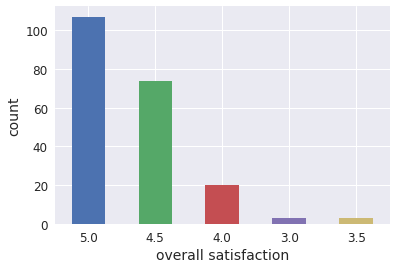

In [22]:
plt.figure(figsize=(6, 4))
zurich_data.overall_satisfaction.value_counts().plot(kind='bar')
plt.xticks(rotation=0)
plt.ylabel('count')
plt.xlabel('overall satisfaction')
plt.show()

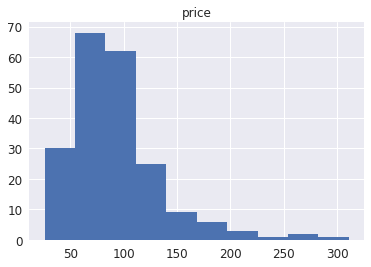

In [23]:
zurich_data[['price']].hist(figsize=(6,4))
plt.show()

Price feature is tail heavy, i.e. it extends much farther to the right of the median than to the left. This may make it a bit harder for some ML algorithms to detect patterns. I will try transforming price attribute to a more bell-shaped distribution.

In [24]:
zurich_data['price_tran'] = zurich_data['price'].apply(lambda x: np.sign(x) * np.log(1 + np.abs(x)))

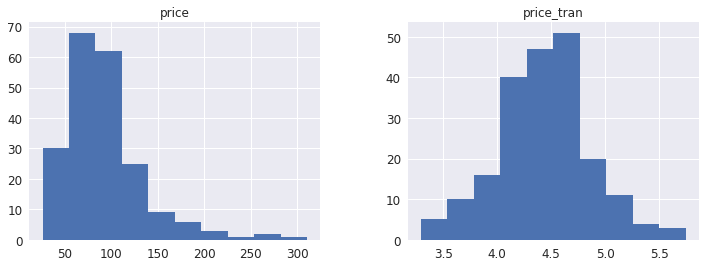

In [25]:
zurich_data[['price', 'price_tran']].hist(figsize=(12, 4))
plt.show()

Drop redundant features from the Airbnb dataset

In [26]:
features_to_drop=['reviews', 
                  'accommodates',
                  'bedrooms',
                  'bathrooms', 
                  'price', 
                  'minstay',
                  'last_modified', 
                  'survey_id',
                  'host_id',
                  'country',
                  'city',
                  'location', 
                  'price']
zurich_data.drop(features_to_drop, axis=1, inplace=True)

In [27]:
zurich_data.head()

,room_id,room_type,neighborhood,overall_satisfaction,latitude,longitude,price_tran
0,71315,Entire home/apt,Kreis 3,4.5,47.374082,8.516890,4.595120
1,274109,Private room,Kreis 11,5.0,47.409038,8.531491,3.970292
2,425996,Private room,Kreis 3,4.5,47.376023,8.510156,4.418841
3,434784,Entire home/apt,Kreis 3,4.5,47.373439,8.518441,4.736198
4,478764,Private room,Kreis 5,4.5,47.383378,8.528108,4.477337


### Generate Maps

In [28]:
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

In [29]:
address = 'Zurich City, Switzerland'

geolocator = Nominatim(user_agent="zh_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Zurich City are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Zurich City are 47.3723941, 8.5423328.


In [30]:
#!conda install -c conda-forge folium=0.5.0 --yes
import folium

In [31]:
# create map of Zurich using latitude and longitude values
map_zurich = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, neighborhood, room_type, score in zip(zurich_data['latitude'], zurich_data['longitude'], 
                                 zurich_data['neighborhood'], zurich_data['room_type'], zurich_data['overall_satisfaction']):
    label = '{}, {}, satisfaction: {}'.format(neighborhood, room_type, score)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_zurich)

map_zurich

## Analyze Each Airbnb Listing <a name="analysis"></a>

I decided to work only with listings in the neighborhoods around Zurich lake, i.e. Kreis 1, 2 and 8

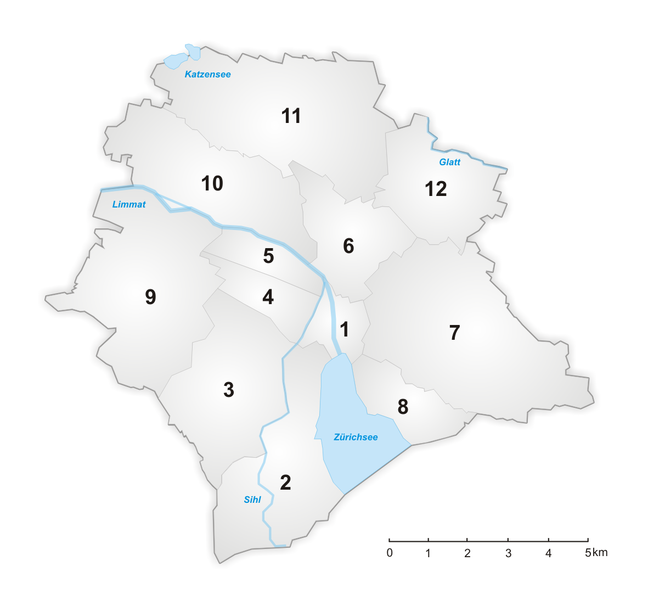

In [32]:
zurich_filtered = zurich_data[zurich_data.neighborhood.isin(['Kreis 1', 'Kreis 2', 'Kreis 8'])].reset_index(drop=True)

In [33]:
zurich_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 7 columns):
room_id                 33 non-null int64
room_type               33 non-null object
neighborhood            33 non-null object
overall_satisfaction    33 non-null float64
latitude                33 non-null float64
longitude               33 non-null float64
price_tran              33 non-null float64
dtypes: float64(4), int64(1), object(2)
memory usage: 1.9+ KB


In [34]:
zurich_filtered.head()

,room_id,room_type,neighborhood,overall_satisfaction,latitude,longitude,price_tran
0,1034594,Entire home/apt,Kreis 1,4.0,47.373248,8.543547,4.890349
1,1556911,Private room,Kreis 8,4.5,47.355421,8.572147,4.430817
2,2912760,Entire home/apt,Kreis 1,4.5,47.372528,8.544669,5.337538
3,3382719,Entire home/apt,Kreis 1,4.5,47.371408,8.540681,5.105945
4,3896966,Private room,Kreis 2,5.0,47.338622,8.539026,4.543295


In [35]:
print('The dataframe has {} neighborhoods and {} listings.'.format(len(zurich_filtered['neighborhood'].unique()), zurich_filtered.shape[0]))

The dataframe has 3 neighborhoods and 33 listings.


In [36]:
zurich_filtered.neighborhood.value_counts()

Kreis 1    13
Kreis 8    10
Kreis 2    10
Name: neighborhood, dtype: int64

In [37]:
address = 'Zurich City, Switzerland'

geolocator = Nominatim(user_agent="zh_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Zurich City are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Zurich City are 47.3723941, 8.5423328.


In [38]:
# create map of Zurich using latitude and longitude values
map_zurich = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for lat, lng, room_id, neighborhood, room_type, score in zip(zurich_filtered['latitude'], zurich_filtered['longitude'], zurich_filtered['room_id'],
                                 zurich_filtered['neighborhood'], zurich_filtered['room_type'], zurich_filtered['overall_satisfaction']):
    label = '{}, {}, satisfaction: {}'.format(neighborhood, room_type, score)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_zurich)

map_zurich

### Define Foursquare Credentials and Version

In [39]:
CLIENT_ID = 'your Foursquare ID' # your Foursquare ID
CLIENT_SECRET = 'your Foursquare Secret' # your Foursquare Secret
VERSION = '20190605' # Foursquare API version

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: your Foursquare ID
CLIENT_SECRET:your Foursquare Secret


In [40]:
# The code was removed by Watson Studio for sharing.

### Let's explore the first neighborhood in our dataframe.

In [41]:
zurich_filtered.iloc[0,]

room_id                         1034594
room_type               Entire home/apt
neighborhood                    Kreis 1
overall_satisfaction                  4
latitude                        47.3732
longitude                       8.54355
price_tran                      4.89035
Name: 0, dtype: object

Get the listing's latitude and longitude values.

In [42]:
listing_latitude = zurich_filtered.loc[0, 'latitude']
listing_longitude = zurich_filtered.loc[0, 'longitude']
listing_id = zurich_filtered.loc[0, 'room_id']

print('Latitude and longitude values of {} are {}, {}.'.format(listing_id, listing_latitude, listing_longitude))

Latitude and longitude values of 1034594 are 47.373248, 8.543547.


Now, let's get the top 100 venues that are in the first listing within a radius of 500 meters. First, let's create the GET request URL.

In [43]:
radius = 500
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, listing_latitude,
                                                                                                                           listing_longitude, VERSION, radius, LIMIT)

In [44]:
import requests
import json

results = requests.get(url).json()

In [45]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a pandas dataframe.

In [46]:
results['response']['groups'][0]['items'][1]

{'reasons': {'count': 0,
  'items': [{'reasonName': 'globalInteractionReason',
    'summary': 'This spot is popular',
    'type': 'general'}]},
 'referralId': 'e-0-4b058888f964a52009cc22e3-1',
 'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/cafe_',
     'suffix': '.png'},
    'id': '4bf58dd8d48988d16d941735',
    'name': 'Café',
    'pluralName': 'Cafés',
    'primary': True,
    'shortName': 'Café'}],
  'id': '4b058888f964a52009cc22e3',
  'location': {'address': 'Napfgasse 4',
   'cc': 'CH',
   'city': 'Zürich',
   'country': 'Schweiz',
   'distance': 210,
   'formattedAddress': ['Napfgasse 4', '8001 Zürich', 'Schweiz'],
   'labeledLatLngs': [{'label': 'display',
     'lat': 47.371399578915444,
     'lng': 8.544148956275349}],
   'lat': 47.371399578915444,
   'lng': 8.544148956275349,
   'postalCode': '8001',
   'state': 'Zürich'},
  'name': 'Café Schober',
  'photos': {'count': 0, 'groups': []}}}

In [47]:
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Lindenhof,Pedestrian Plaza,47.373005,8.540883
1,Café Schober,Café,47.371400,8.544149
2,Schwarzenbach Kolonialwaren,Gourmet Shop,47.371444,8.544091
3,Old Crow,Cocktail Bar,47.372092,8.541024
4,Äss-Bar,Bakery,47.372561,8.543693


In [48]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


Let's create a function to repeat the same process to all the Airbnb listings in Zurich

In [49]:
def getNearbyVenues(names, neighborhoods, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, neighborhood, lat, lng in zip(names, neighborhoods, latitudes, longitudes):
        print('Room with id {} in {}'.format(name, neighborhood))
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['room_id', 
                  'room_latitude', 
                  'room_longitude', 
                  'venue', 
                  'venue_latitude', 
                  'venue_longitude', 
                  'venue_category']
    
    return(nearby_venues)

In [50]:
zurich_venues = getNearbyVenues(names=zurich_filtered['room_id'], neighborhoods=zurich_filtered['neighborhood'],
                                latitudes=zurich_filtered['latitude'], longitudes=zurich_filtered['longitude'])

Room with id 1034594 in Kreis 1
Room with id 1556911 in Kreis 8
Room with id 2912760 in Kreis 1
Room with id 3382719 in Kreis 1
Room with id 3896966 in Kreis 2
Room with id 4075355 in Kreis 1
Room with id 4177331 in Kreis 2
Room with id 4378277 in Kreis 2
Room with id 5506541 in Kreis 8
Room with id 5688218 in Kreis 2
Room with id 5847661 in Kreis 2
Room with id 6026472 in Kreis 1
Room with id 6087791 in Kreis 1
Room with id 6109796 in Kreis 8
Room with id 6150496 in Kreis 2
Room with id 6430333 in Kreis 8
Room with id 6723252 in Kreis 8
Room with id 6912521 in Kreis 1
Room with id 7042641 in Kreis 2
Room with id 7251135 in Kreis 8
Room with id 7360342 in Kreis 1
Room with id 7504637 in Kreis 8
Room with id 7778104 in Kreis 8
Room with id 7996794 in Kreis 1
Room with id 8056083 in Kreis 1
Room with id 8158459 in Kreis 1
Room with id 8246386 in Kreis 8
Room with id 8388752 in Kreis 2
Room with id 8512411 in Kreis 2
Room with id 8661642 in Kreis 1
Room with id 8717457 in Kreis 1
Room wit

In [51]:
print(zurich_venues.shape)
zurich_venues.head()

(1966, 7)


,room_id,room_latitude,room_longitude,venue,venue_latitude,venue_longitude,venue_category
0,1034594,47.373248,8.543547,Lindenhof,47.373005,8.540883,Pedestrian Plaza
1,1034594,47.373248,8.543547,Café Schober,47.371400,8.544149,Café
2,1034594,47.373248,8.543547,Schwarzenbach Kolonialwaren,47.371444,8.544091,Gourmet Shop
3,1034594,47.373248,8.543547,Old Crow,47.372092,8.541024,Cocktail Bar
4,1034594,47.373248,8.543547,Äss-Bar,47.372561,8.543693,Bakery


Let's check how many venues were returned for each room id

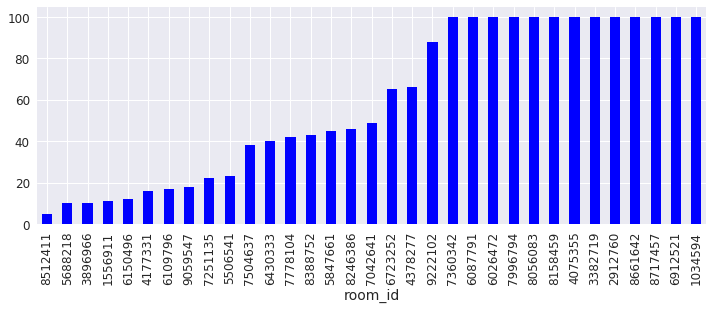

In [52]:
zurich_venues.groupby('room_id')['venue'].count().sort_values().plot(kind='bar', figsize=(12,4), color='b')
plt.show()

In [53]:
print('There are {} unique categories.'.format(len(zurich_venues['venue_category'].unique())))

There are 131 unique categories.


### Explore venues in each category

In [54]:
zurich_venues.columns

Index(['room_id', 'room_latitude', 'room_longitude', 'venue', 'venue_latitude',
       'venue_longitude', 'venue_category'],
      dtype='object')

In [55]:
# one hot encoding
zurich_venue_onehot = pd.get_dummies(zurich_venues[['venue_category']], prefix="", prefix_sep="")

# add room id column back to dataframe
zurich_venue_onehot['room_id'] = zurich_venues['room_id']

# move room id column to the first column
fixed_columns = ['room_id'] + [col for col in zurich_venue_onehot.columns if col != 'room_id']

zurich_venue_onehot = zurich_venue_onehot[fixed_columns]
print(zurich_venue_onehot.shape)
zurich_venue_onehot.head()

(1966, 132)


,room_id,American Restaurant,Argentinian Restaurant,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Automotive Shop,BBQ Joint,Bakery,Bar,Bath House,Bathing Area,Beach,Beer Garden,Bistro,Bookstore,Boutique,Bratwurst Joint,Burger Joint,Bus Station,Café,Campground,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Circus,Clothing Store,Cocktail Bar,Coffee Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Department Store,Dessert Shop,Diner,Electronics Store,Fast Food Restaurant,Flea Market,Food Court,French Restaurant,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,Gift Shop,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hawaiian Restaurant,History Museum,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Island,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Light Rail Station,Liquor Store,Lounge,Market,Medical Center,Mediterranean Restaurant,Mexican Restaurant,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nightclub,Opera House,Optical Shop,Park,Pedestrian Plaza,Performing Arts Venue,Pet Store,Pharmacy,Pier,Pizza Place,Platform,Playground,Plaza,Pool,Restaurant,River,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Tapas Restaurant,Taverna,Thai Restaurant,Theater,Trail,Train Station,Tram Station,Trattoria/Osteria,Vegetarian / Vegan Restaurant,Waterfront,Wine Bar,Wine Shop
0,1034594,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1034594,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1034594,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1034594,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1034594,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Next, let's group rows by room_id and by taking the mean of the frequency of occurrence of each category

In [56]:
zurich_venue_grp = zurich_venue_onehot.groupby(['room_id']).mean().reset_index()
print(zurich_venue_grp.shape)
zurich_venue_grp.head()

(33, 132)


,room_id,American Restaurant,Argentinian Restaurant,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Automotive Shop,BBQ Joint,Bakery,Bar,Bath House,Bathing Area,Beach,Beer Garden,Bistro,Bookstore,Boutique,Bratwurst Joint,Burger Joint,Bus Station,Café,Campground,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Circus,Clothing Store,Cocktail Bar,Coffee Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Department Store,Dessert Shop,Diner,Electronics Store,Fast Food Restaurant,Flea Market,Food Court,French Restaurant,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,Gift Shop,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hawaiian Restaurant,History Museum,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Island,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Light Rail Station,Liquor Store,Lounge,Market,Medical Center,Mediterranean Restaurant,Mexican Restaurant,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nightclub,Opera House,Optical Shop,Park,Pedestrian Plaza,Performing Arts Venue,Pet Store,Pharmacy,Pier,Pizza Place,Platform,Playground,Plaza,Pool,Restaurant,River,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Tapas Restaurant,Taverna,Thai Restaurant,Theater,Trail,Train Station,Tram Station,Trattoria/Osteria,Vegetarian / Vegan Restaurant,Waterfront,Wine Bar,Wine Shop
0,1034594,0.0,0.01,0.01,0.02,0.01,0.0,0.0,0.00,0.0,0.010000,0.06,0.0,0.0,0.0,0.0,0.0,0.00,0.01,0.0,0.01,0.0,0.070000,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.03,0.00,0.0,0.0,0.0,0.00,0.02,0.01,0.01,0.03,0.01,0.0,0.01,0.0,0.06,0.01,0.01,0.0,0.0,0.01,0.01,0.02,0.010000,0.0,0.01,0.0,0.0,0.0,0.0,0.05,0.01,0.0,0.0,0.0,0.0,0.05,0.0,0.00,0.0,0.0,0.0,0.04,0.0,0.000000,0.01,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.01,0.02,0.01,0.0,0.0,0.0,0.01,0.0,0.0,0.02,0.00,0.04,0.0,0.0,0.0,0.01,0.01,0.01,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.01,0.01,0.01,0.0,0.130000,0.0,0.0,0.02,0.0,0.0,0.0,0.000000,0.0,0.01,0.0,0.01,0.000000
1,1556911,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.181818,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.090909,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.090909,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.090909,0.00,0.0,0.0,0.090909,0.0,0.0,0.090909,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.181818,0.0,0.0,0.00,0.0,0.0,0.0,0.090909,0.0,0.00,0.0,0.00,0.090909
2,2912760,0.0,0.00,0.01,0.02,0.00,0.0,0.0,0.00,0.0,0.010000,0.07,0.0,0.0,0.0,0.0,0.0,0.00,0.02,0.0,0.01,0.0,0.090000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.03,0.00,0.0,0.0,0.0,0.01,0.01,0.01,0.01,0.02,0.00,0.0,0.01,0.0,0.07,0.01,0.01,0.0,0.0,0.01,0.01,0.01,0.000000,0.0,0.01,0.0,0.0,0.0,0.0,0.05,0.01,0.0,0.0,0.0,0.0,0.05,0.0,0.00,0.0,0.0,0.0,0.04,0.0,0.000000,0.01,0.0,0.0,0.000000,0.0,0.0,0.000000,0.01,0.0,0.0,0.0,0.0,0.01,0.02,0.01,0.0,0.0,0.0,0.01,0.0,0.0,0.03,0.01,0.04,0.0,0.0,0.0,0.01,0.01,0.01,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.01,0.01,0.00,0.0,0.140000,0.0,0.0,0.02,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.01,0.000000
3,3382719,0.0,0.02,0.00,0.02,0.01,0.0,0.0,0.01,0.0,0.010000,0.04,0.0,0.0,0.0,0.0,0.0,0.01,0.06,0.0,0.00,0.0,0.100000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.05,0.01,0.0,0.0,0.0,0.00,0.01,0.02,0.03,0.01,0.00,0.0,0.00,0.0,0.04,0.00,0.00,0.0,0.0,0.01,0.01,0.01,0.000000,0.0,0.01,0.0,0.0,0.0,0.0,0.04,0.01,0.0,0.0,0.0,0.0,0.04,0.0,0.03,0.0,0.0,0.0,0.03,0.0,0.000000,0.00,0.0,0.0

Let's print each room_id along with the top 5 most common venues

In [57]:
num_top_venues = 5

for hood in zurich_venue_grp['room_id']:
    print("----"+str(hood)+"----")
    temp = zurich_venue_grp[zurich_venue_grp['room_id'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----1034594----
                venue  freq
0    Swiss Restaurant  0.13
1                Café  0.07
2                 Bar  0.06
3   French Restaurant  0.06
4  Italian Restaurant  0.05


----1556911----
              venue  freq
0            Bakery  0.18
1  Swiss Restaurant  0.18
2         Wine Shop  0.09
3     Grocery Store  0.09
4    Medical Center  0.09


----2912760----
                venue  freq
0    Swiss Restaurant  0.14
1                Café  0.09
2   French Restaurant  0.07
3                 Bar  0.07
4  Italian Restaurant  0.05


----3382719----
              venue  freq
0              Café  0.10
1  Swiss Restaurant  0.09
2        Restaurant  0.06
3          Boutique  0.06
4      Cocktail Bar  0.05


----3896966----
              venue  freq
0       Bus Station   0.3
1   Harbor / Marina   0.2
2  Swiss Restaurant   0.2
3        Restaurant   0.1
4              Pool   0.1


----4075355----
               venue  freq
0   Swiss Restaurant  0.14
1               Café  0.10
2        

In [58]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create the new dataframe and display the top 10 venues for each room_id

In [59]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['room_id']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
zurich_venues_sorted = pd.DataFrame(columns=columns)
zurich_venues_sorted['room_id'] = zurich_venue_grp['room_id']

for ind in np.arange(zurich_venue_grp.shape[0]):
    zurich_venues_sorted.iloc[ind, 1:] = return_most_common_venues(zurich_venue_grp.iloc[ind, :], num_top_venues)

zurich_venues_sorted.head()

,room_id,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1034594,Swiss Restaurant,Café,Bar,French Restaurant,Italian Restaurant,Hotel,Lounge,Restaurant,Diner,Cocktail Bar
1,1556911,Bakery,Swiss Restaurant,Wine Shop,Café,Modern European Restaurant,Grocery Store,Medical Center,Museum,Tram Station,Fast Food Restaurant
2,2912760,Swiss Restaurant,Café,French Restaurant,Bar,Italian Restaurant,Hotel,Lounge,Restaurant,Cocktail Bar,Plaza
3,3382719,Café,Swiss Restaurant,Boutique,Restaurant,Cocktail Bar,Bar,French Restaurant,Hotel,Italian Restaurant,Plaza
4,3896966,Bus Station,Harbor / Marina,Swiss Restaurant,Campground,Pool,Restaurant,Cupcake Shop,Department Store,Dessert Shop,Diner


## Prepare data for Machine Learning <a name="preparation"></a>

### Merge venues with price and overall satisfaction features

In [60]:
print(zurich_venue_grp.shape)
zurich_venue_grp.head()

(33, 132)


,room_id,American Restaurant,Argentinian Restaurant,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Automotive Shop,BBQ Joint,Bakery,Bar,Bath House,Bathing Area,Beach,Beer Garden,Bistro,Bookstore,Boutique,Bratwurst Joint,Burger Joint,Bus Station,Café,Campground,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Circus,Clothing Store,Cocktail Bar,Coffee Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Department Store,Dessert Shop,Diner,Electronics Store,Fast Food Restaurant,Flea Market,Food Court,French Restaurant,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,Gift Shop,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hawaiian Restaurant,History Museum,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Island,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Light Rail Station,Liquor Store,Lounge,Market,Medical Center,Mediterranean Restaurant,Mexican Restaurant,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nightclub,Opera House,Optical Shop,Park,Pedestrian Plaza,Performing Arts Venue,Pet Store,Pharmacy,Pier,Pizza Place,Platform,Playground,Plaza,Pool,Restaurant,River,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Tapas Restaurant,Taverna,Thai Restaurant,Theater,Trail,Train Station,Tram Station,Trattoria/Osteria,Vegetarian / Vegan Restaurant,Waterfront,Wine Bar,Wine Shop
0,1034594,0.0,0.01,0.01,0.02,0.01,0.0,0.0,0.00,0.0,0.010000,0.06,0.0,0.0,0.0,0.0,0.0,0.00,0.01,0.0,0.01,0.0,0.070000,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.03,0.00,0.0,0.0,0.0,0.00,0.02,0.01,0.01,0.03,0.01,0.0,0.01,0.0,0.06,0.01,0.01,0.0,0.0,0.01,0.01,0.02,0.010000,0.0,0.01,0.0,0.0,0.0,0.0,0.05,0.01,0.0,0.0,0.0,0.0,0.05,0.0,0.00,0.0,0.0,0.0,0.04,0.0,0.000000,0.01,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.01,0.02,0.01,0.0,0.0,0.0,0.01,0.0,0.0,0.02,0.00,0.04,0.0,0.0,0.0,0.01,0.01,0.01,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.01,0.01,0.01,0.0,0.130000,0.0,0.0,0.02,0.0,0.0,0.0,0.000000,0.0,0.01,0.0,0.01,0.000000
1,1556911,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.181818,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.090909,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.090909,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.090909,0.00,0.0,0.0,0.090909,0.0,0.0,0.090909,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.181818,0.0,0.0,0.00,0.0,0.0,0.0,0.090909,0.0,0.00,0.0,0.00,0.090909
2,2912760,0.0,0.00,0.01,0.02,0.00,0.0,0.0,0.00,0.0,0.010000,0.07,0.0,0.0,0.0,0.0,0.0,0.00,0.02,0.0,0.01,0.0,0.090000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.03,0.00,0.0,0.0,0.0,0.01,0.01,0.01,0.01,0.02,0.00,0.0,0.01,0.0,0.07,0.01,0.01,0.0,0.0,0.01,0.01,0.01,0.000000,0.0,0.01,0.0,0.0,0.0,0.0,0.05,0.01,0.0,0.0,0.0,0.0,0.05,0.0,0.00,0.0,0.0,0.0,0.04,0.0,0.000000,0.01,0.0,0.0,0.000000,0.0,0.0,0.000000,0.01,0.0,0.0,0.0,0.0,0.01,0.02,0.01,0.0,0.0,0.0,0.01,0.0,0.0,0.03,0.01,0.04,0.0,0.0,0.0,0.01,0.01,0.01,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.01,0.01,0.00,0.0,0.140000,0.0,0.0,0.02,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.01,0.000000
3,3382719,0.0,0.02,0.00,0.02,0.01,0.0,0.0,0.01,0.0,0.010000,0.04,0.0,0.0,0.0,0.0,0.0,0.01,0.06,0.0,0.00,0.0,0.100000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.05,0.01,0.0,0.0,0.0,0.00,0.01,0.02,0.03,0.01,0.00,0.0,0.00,0.0,0.04,0.00,0.00,0.0,0.0,0.01,0.01,0.01,0.000000,0.0,0.01,0.0,0.0,0.0,0.0,0.04,0.01,0.0,0.0,0.0,0.0,0.04,0.0,0.03,0.0,0.0,0.0,0.03,0.0,0.000000,0.00,0.0,0.0

In [61]:
print(zurich_filtered.shape)
zurich_filtered.head()

(33, 7)


,room_id,room_type,neighborhood,overall_satisfaction,latitude,longitude,price_tran
0,1034594,Entire home/apt,Kreis 1,4.0,47.373248,8.543547,4.890349
1,1556911,Private room,Kreis 8,4.5,47.355421,8.572147,4.430817
2,2912760,Entire home/apt,Kreis 1,4.5,47.372528,8.544669,5.337538
3,3382719,Entire home/apt,Kreis 1,4.5,47.371408,8.540681,5.105945
4,3896966,Private room,Kreis 2,5.0,47.338622,8.539026,4.543295


In [62]:
zurich_grp = zurich_filtered[['room_id', 'price_tran', 'overall_satisfaction']].merge(zurich_venue_grp, on='room_id')
print(zurich_grp.shape)
zurich_grp.head()

(33, 134)


,room_id,price_tran,overall_satisfaction,American Restaurant,Argentinian Restaurant,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Automotive Shop,BBQ Joint,Bakery,Bar,Bath House,Bathing Area,Beach,Beer Garden,Bistro,Bookstore,Boutique,Bratwurst Joint,Burger Joint,Bus Station,Café,Campground,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Circus,Clothing Store,Cocktail Bar,Coffee Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Department Store,Dessert Shop,Diner,Electronics Store,Fast Food Restaurant,Flea Market,Food Court,French Restaurant,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,Gift Shop,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hawaiian Restaurant,History Museum,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Island,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Light Rail Station,Liquor Store,Lounge,Market,Medical Center,Mediterranean Restaurant,Mexican Restaurant,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nightclub,Opera House,Optical Shop,Park,Pedestrian Plaza,Performing Arts Venue,Pet Store,Pharmacy,Pier,Pizza Place,Platform,Playground,Plaza,Pool,Restaurant,River,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Tapas Restaurant,Taverna,Thai Restaurant,Theater,Trail,Train Station,Tram Station,Trattoria/Osteria,Vegetarian / Vegan Restaurant,Waterfront,Wine Bar,Wine Shop
0,1034594,4.890349,4.0,0.0,0.01,0.01,0.02,0.01,0.0,0.0,0.00,0.0,0.010000,0.06,0.0,0.0,0.0,0.0,0.0,0.00,0.01,0.0,0.01,0.0,0.070000,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.03,0.00,0.0,0.0,0.0,0.00,0.02,0.01,0.01,0.03,0.01,0.0,0.01,0.0,0.06,0.01,0.01,0.0,0.0,0.01,0.01,0.02,0.010000,0.0,0.01,0.0,0.0,0.0,0.0,0.05,0.01,0.0,0.0,0.0,0.0,0.05,0.0,0.00,0.0,0.0,0.0,0.04,0.0,0.000000,0.01,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.01,0.02,0.01,0.0,0.0,0.0,0.01,0.0,0.0,0.02,0.00,0.04,0.0,0.0,0.0,0.01,0.01,0.01,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.01,0.01,0.01,0.0,0.130000,0.0,0.0,0.02,0.0,0.0,0.0,0.000000,0.0,0.01,0.0,0.01,0.000000
1,1556911,4.430817,4.5,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.181818,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.090909,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.090909,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.090909,0.00,0.0,0.0,0.090909,0.0,0.0,0.090909,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.181818,0.0,0.0,0.00,0.0,0.0,0.0,0.090909,0.0,0.00,0.0,0.00,0.090909
2,2912760,5.337538,4.5,0.0,0.00,0.01,0.02,0.00,0.0,0.0,0.00,0.0,0.010000,0.07,0.0,0.0,0.0,0.0,0.0,0.00,0.02,0.0,0.01,0.0,0.090000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.03,0.00,0.0,0.0,0.0,0.01,0.01,0.01,0.01,0.02,0.00,0.0,0.01,0.0,0.07,0.01,0.01,0.0,0.0,0.01,0.01,0.01,0.000000,0.0,0.01,0.0,0.0,0.0,0.0,0.05,0.01,0.0,0.0,0.0,0.0,0.05,0.0,0.00,0.0,0.0,0.0,0.04,0.0,0.000000,0.01,0.0,0.0,0.000000,0.0,0.0,0.000000,0.01,0.0,0.0,0.0,0.0,0.01,0.02,0.01,0.0,0.0,0.0,0.01,0.0,0.0,0.03,0.01,0.04,0.0,0.0,0.0,0.01,0.01,0.01,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.01,0.01,0.00,0.0,0.140000,0.0,0.0,0.02,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.01,0.000000
3,3382719,5.105945,4.5,0.0,0.02,0.00,0.02,0.01,0.0,0.0,0.01,0.0,0.010000,0.04,0.0,0.0,0.0,0.0,0.0,0.01,0.06,0.0,0.00,0.0,0.100000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.05,0.01,0.0,0.0,0.0,0.00,0.01,0.02,0.03,0.01,0.00,0.0,0.00,0.0,0.04,0.00,0.00,0.0,0.0,0.01,0.01,0.01,0.000000,0.0,0.01,0.0,0.0,0.0,0.

### Data Scaling

Now let's normalize the dataset. Normalization is a statistical method that helps mathematical-based algorithms interpret features with different magnitudes and distributions equally. We use StandardScaler() to normalize our dataset.

In [63]:
from sklearn.preprocessing import StandardScaler

X = zurich_grp.drop(['room_id'], axis=1).values
print(X.shape)
cluster_dataset = StandardScaler().fit_transform(X)
cluster_dataset

(33, 133)


array([[ 0.48703972, -1.74197668, -0.22997598, ..., -0.25345123,
         0.30877374, -0.24402799],
       [-0.63183195, -0.43549417, -0.22997598, ..., -0.25345123,
        -0.92483452,  5.33536474],
       [ 1.57585767, -0.43549417, -0.22997598, ..., -0.25345123,
         0.30877374, -0.24402799],
       ..., 
       [-0.63183195, -1.74197668, -0.22997598, ..., -0.25345123,
         0.30877374, -0.24402799],
       [-1.14632841, -0.43549417, -0.22997598, ..., -0.25345123,
        -0.92483452, -0.24402799],
       [ 1.81004678, -0.43549417,  0.553452  , ...,  4.1954267 ,
        -0.92483452, -0.24402799]])

## Cluster Airbnb Listings <a name="clustering"></a>

Run k-means to cluster the listings into 5 clusters.

In [64]:
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cluster_dataset)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 0, 1, 1, 0, 1, 0, 1, 3, 0], dtype=int32)

In [65]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=0).fit(cluster_dataset) for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

I cannot simply take the value of $k$ that minimizes the inertia, since it keeps getting lower as we increase $k$. Indeed, the more clusters there are, the closer each instance will be to its closest centroid, and therefore the lower the inertia will be. However, we can plot the inertia as a function of $k$ and analyze the resulting curve:

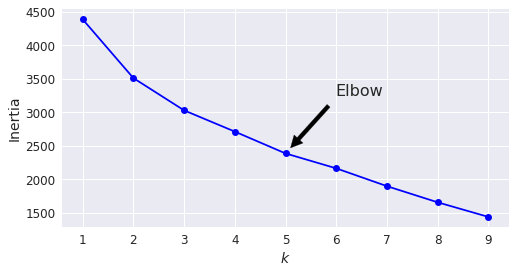

In [66]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(5, inertias[4]),
             xytext=(0.65, 0.65),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.show()

As you can see, after $k=5$ the decrease in the inertia is less steep as for smaller values of $k$. So $k=5$ is a pretty good choice.

# Results <a name="results"></a>

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each listing.

In [67]:
# add clustering labels
zurich_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

zurich_merged = zurich_filtered

# merge zurich grouped with zurich center data to add latitude/longitude for each listing
zurich_merged = zurich_merged.join(zurich_venues_sorted.set_index('room_id'), on='room_id')

zurich_merged.head()

,room_id,room_type,neighborhood,overall_satisfaction,latitude,longitude,price_tran,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1034594,Entire home/apt,Kreis 1,4.0,47.373248,8.543547,4.890349,1,Swiss Restaurant,Café,Bar,French Restaurant,Italian Restaurant,Hotel,Lounge,Restaurant,Diner,Cocktail Bar
1,1556911,Private room,Kreis 8,4.5,47.355421,8.572147,4.430817,0,Bakery,Swiss Restaurant,Wine Shop,Café,Modern European Restaurant,Grocery Store,Medical Center,Museum,Tram Station,Fast Food Restaurant
2,2912760,Entire home/apt,Kreis 1,4.5,47.372528,8.544669,5.337538,1,Swiss Restaurant,Café,French Restaurant,Bar,Italian Restaurant,Hotel,Lounge,Restaurant,Cocktail Bar,Plaza
3,3382719,Entire home/apt,Kreis 1,4.5,47.371408,8.540681,5.105945,1,Café,Swiss Restaurant,Boutique,Restaurant,Cocktail Bar,Bar,French Restaurant,Hotel,Italian Restaurant,Plaza
4,3896966,Private room,Kreis 2,5.0,47.338622,8.539026,4.543295,0,Bus Station,Harbor / Marina,Swiss Restaurant,Campground,Pool,Restaurant,Cupcake Shop,Department Store,Dessert Shop,Diner


In [68]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(zurich_merged['latitude'], zurich_merged['longitude'], zurich_merged['room_id'], zurich_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

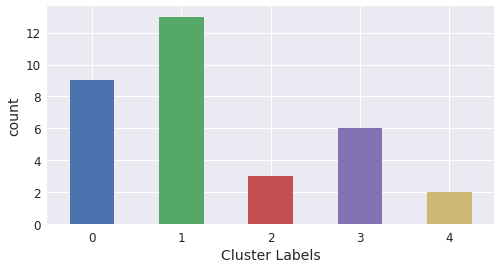

In [69]:
zurich_merged.groupby('Cluster Labels')['room_id'].count().plot(kind='bar', figsize=(8, 4))
plt.xticks(rotation=0)
plt.ylabel('count')
plt.show()

In [70]:
zurich_merged.loc[zurich_merged['Cluster Labels'] == 0, zurich_merged.columns[[1] + list(range(5, zurich_merged.shape[1]))]]

,room_type,longitude,price_tran,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Private room,8.572147,4.430817,0,Bakery,Swiss Restaurant,Wine Shop,Café,Modern European Restaurant,Grocery Store,Medical Center,Museum,Tram Station,Fast Food Restaurant
4,Private room,8.539026,4.543295,0,Bus Station,Harbor / Marina,Swiss Restaurant,Campground,Pool,Restaurant,Cupcake Shop,Department Store,Dessert Shop,Diner
6,Entire home/apt,8.530514,5.560682,0,Supermarket,Bus Station,Tram Station,Restaurant,Island,Hostel,Train Station,Gas Station,Fast Food Restaurant,Salon / Barbershop
9,Private room,8.539231,4.110874,0,Bus Station,Harbor / Marina,Swiss Restaurant,Campground,Pool,Restaurant,Cupcake Shop,Department Store,Dessert Shop,Diner
13,Entire home/apt,8.561526,4.543295,0,Museum,Swiss Restaurant,Restaurant,Gym,Clothing Store,Park,Food Court,Café,Snack Place,Convenience Store
14,Private room,8.528038,3.713572,0,Park,Bus Station,American Restaurant,Sporting Goods Shop,Museum,Clothing Store,Skate Park,Restaurant,Athletics & Sports,Automotive Shop
19,Entire home/apt,8.561444,5.231109,0,Restaurant,Italian Restaurant,Tram Station,Museum,Swiss Restaurant,Bistro,Supermarket,Park,Food Court,Café
28,Entire home/apt,8.519600,4.644391,0,Light Rail Station,Convenience Store,Bus Station,Trail,Fast Food Restaurant,Garden,Furniture / Home Store,French Restaurant,Food Court,Flea Market
31,Private room,8.534835,4.219508,0,Swiss Restaurant,Tram Station,Bus Station,Supermarket,Restaurant,Pier,Pool,Salon / Barbershop,Cheese Shop,Fast Food Restaurant


In [71]:
zurich_merged.loc[zurich_merged['Cluster Labels'] == 1, zurich_merged.columns[[1] + list(range(5, zurich_merged.shape[1]))]]

,room_type,longitude,price_tran,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Entire home/apt,8.543547,4.890349,1,Swiss Restaurant,Café,Bar,French Restaurant,Italian Restaurant,Hotel,Lounge,Restaurant,Diner,Cocktail Bar
2,Entire home/apt,8.544669,5.337538,1,Swiss Restaurant,Café,French Restaurant,Bar,Italian Restaurant,Hotel,Lounge,Restaurant,Cocktail Bar,Plaza
3,Entire home/apt,8.540681,5.105945,1,Café,Swiss Restaurant,Boutique,Restaurant,Cocktail Bar,Bar,French Restaurant,Hotel,Italian Restaurant,Plaza
5,Private room,8.544342,4.736198,1,Swiss Restaurant,Café,Bar,French Restaurant,Italian Restaurant,Hotel,Restaurant,Cocktail Bar,Plaza,Boutique
7,Entire home/apt,8.532492,4.653960,1,Bar,Hotel,Restaurant,Coffee Shop,Swiss Restaurant,Café,Italian Restaurant,Gym / Fitness Center,Supermarket,Wine Shop
11,Entire home/apt,8.541214,4.820282,1,Swiss Restaurant,Café,French Restaurant,Bar,Boutique,Lounge,Hotel,Cocktail Bar,Dessert Shop,Italian Restaurant
17,Entire home/apt,8.543025,4.369448,1,Swiss Restaurant,Bar,Café,French Restaurant,Italian Restaurant,Hotel,Lounge,Plaza,Diner,Restaurant
20,Entire home/apt,8.545664,5.111988,1,Swiss Restaurant,Café,Bar,French Restaurant,Restaurant,Hotel,Italian Restaurant,Plaza,Cocktail Bar,Diner
23,Entire home/apt,8.544182,4.948760,1,Swiss Restaurant,Café,French Restaurant,Bar,Italian Restaurant,Hotel,Restaurant,Lounge,Cocktail Bar,Diner
24,Entire home/apt,8.541224,5.043425,1,Swiss Restaurant,Café,French Restaurant,Restaurant,Boutique,Lounge,Hotel,Cocktail Bar,Bar,Pedestrian Plaza


In [72]:
zurich_merged.loc[zurich_merged['Cluster Labels'] == 2, zurich_merged.columns[[1] + list(range(5, zurich_merged.shape[1]))]]

,room_type,longitude,price_tran,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Shared room,8.526016,4.060443,2,Hotel,Italian Restaurant,Swiss Restaurant,Bakery,Café,Park,Clothing Store,Restaurant,Plaza,Playground
18,Private room,8.525316,4.532599,2,Hotel,Italian Restaurant,Supermarket,History Museum,Restaurant,Tram Station,Train Station,Plaza,Swiss Restaurant,Japanese Restaurant
27,Private room,8.528693,4.653960,2,Italian Restaurant,Restaurant,Tram Station,Park,Swiss Restaurant,Hotel,Bakery,History Museum,Concert Hall,Bookstore


In [73]:
zurich_merged.loc[zurich_merged['Cluster Labels'] == 3, zurich_merged.columns[[1] + list(range(5, zurich_merged.shape[1]))]]

,room_type,longitude,price_tran,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Entire home/apt,8.552891,4.532599,3,Restaurant,Bakery,Park,Movie Theater,Swiss Restaurant,Seafood Restaurant,Beer Garden,Beach,Bathing Area,Supermarket
15,Private room,8.553526,3.951244,3,Italian Restaurant,Café,Art Museum,Hotel,Restaurant,Supermarket,Playground,Salad Place,Swiss Restaurant,Bakery
16,Entire home/apt,8.551578,4.736198,3,Hotel,Italian Restaurant,Café,Japanese Restaurant,Bar,Salad Place,Supermarket,Indian Restaurant,Swiss Restaurant,Asian Restaurant
21,Entire home/apt,8.550277,4.574711,3,Hotel,Italian Restaurant,Café,Salad Place,Japanese Restaurant,Art Museum,Restaurant,Bakery,Bar,Supermarket
22,Entire home/apt,8.550522,4.624973,3,Hotel,Café,Italian Restaurant,Restaurant,Art Museum,Bar,Supermarket,Bakery,Park,Salad Place
26,Entire home/apt,8.553301,4.644391,3,Restaurant,Park,Italian Restaurant,Movie Theater,Bakery,Supermarket,Café,Art Museum,Tram Station,Swiss Restaurant


In [74]:
zurich_merged.loc[zurich_merged['Cluster Labels'] == 4, zurich_merged.columns[[1] + list(range(5, zurich_merged.shape[1]))]]

,room_type,longitude,price_tran,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Entire home/apt,8.544306,4.983607,4,Swiss Restaurant,Hotel,Café,Bar,Plaza,French Restaurant,Italian Restaurant,Boutique,Restaurant,Lounge
32,Entire home/apt,8.549923,5.433722,4,Hotel,Italian Restaurant,Coffee Shop,Asian Restaurant,Bakery,Café,Japanese Restaurant,Restaurant,Salad Place,Bar


# Discussion and Recommendations <a name="discussion"></a>

Each row in our dataset represents an Airbnb listing, and therefore, each row is assigned a label

In [75]:
zurich_grp['Labels'] = kmeans.labels_
zurich_grp.drop(['room_id'], axis=1, inplace=True)
zurich_grp.head()

,price_tran,overall_satisfaction,American Restaurant,Argentinian Restaurant,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Automotive Shop,BBQ Joint,Bakery,Bar,Bath House,Bathing Area,Beach,Beer Garden,Bistro,Bookstore,Boutique,Bratwurst Joint,Burger Joint,Bus Station,Café,Campground,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Circus,Clothing Store,Cocktail Bar,Coffee Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Department Store,Dessert Shop,Diner,Electronics Store,Fast Food Restaurant,Flea Market,Food Court,French Restaurant,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,Gift Shop,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hawaiian Restaurant,History Museum,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Island,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Light Rail Station,Liquor Store,Lounge,Market,Medical Center,Mediterranean Restaurant,Mexican Restaurant,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nightclub,Opera House,Optical Shop,Park,Pedestrian Plaza,Performing Arts Venue,Pet Store,Pharmacy,Pier,Pizza Place,Platform,Playground,Plaza,Pool,Restaurant,River,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Tapas Restaurant,Taverna,Thai Restaurant,Theater,Trail,Train Station,Tram Station,Trattoria/Osteria,Vegetarian / Vegan Restaurant,Waterfront,Wine Bar,Wine Shop,Labels
0,4.890349,4.0,0.0,0.01,0.01,0.02,0.01,0.0,0.0,0.00,0.0,0.010000,0.06,0.0,0.0,0.0,0.0,0.0,0.00,0.01,0.0,0.01,0.0,0.070000,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.03,0.00,0.0,0.0,0.0,0.00,0.02,0.01,0.01,0.03,0.01,0.0,0.01,0.0,0.06,0.01,0.01,0.0,0.0,0.01,0.01,0.02,0.010000,0.0,0.01,0.0,0.0,0.0,0.0,0.05,0.01,0.0,0.0,0.0,0.0,0.05,0.0,0.00,0.0,0.0,0.0,0.04,0.0,0.000000,0.01,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.01,0.02,0.01,0.0,0.0,0.0,0.01,0.0,0.0,0.02,0.00,0.04,0.0,0.0,0.0,0.01,0.01,0.01,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.01,0.01,0.01,0.0,0.130000,0.0,0.0,0.02,0.0,0.0,0.0,0.000000,0.0,0.01,0.0,0.01,0.000000,1
1,4.430817,4.5,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.181818,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.090909,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.090909,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.090909,0.00,0.0,0.0,0.090909,0.0,0.0,0.090909,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.181818,0.0,0.0,0.00,0.0,0.0,0.0,0.090909,0.0,0.00,0.0,0.00,0.090909,0
2,5.337538,4.5,0.0,0.00,0.01,0.02,0.00,0.0,0.0,0.00,0.0,0.010000,0.07,0.0,0.0,0.0,0.0,0.0,0.00,0.02,0.0,0.01,0.0,0.090000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.03,0.00,0.0,0.0,0.0,0.01,0.01,0.01,0.01,0.02,0.00,0.0,0.01,0.0,0.07,0.01,0.01,0.0,0.0,0.01,0.01,0.01,0.000000,0.0,0.01,0.0,0.0,0.0,0.0,0.05,0.01,0.0,0.0,0.0,0.0,0.05,0.0,0.00,0.0,0.0,0.0,0.04,0.0,0.000000,0.01,0.0,0.0,0.000000,0.0,0.0,0.000000,0.01,0.0,0.0,0.0,0.0,0.01,0.02,0.01,0.0,0.0,0.0,0.01,0.0,0.0,0.03,0.01,0.04,0.0,0.0,0.0,0.01,0.01,0.01,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.01,0.01,0.00,0.0,0.140000,0.0,0.0,0.02,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.01,0.000000,1
3,5.105945,4.5,0.0,0.02,0.00,0.02,0.01,0.0,0.0,0.01,0.0,0.010000,0.04,0.0,0.0,0.0,0.0,0.0,0.01,0.06,0.0,0.00,0.0,0.100000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.05,0.01,0.0,0.0,0.0,0.00,0.01,0.02,0.03,0.01,0.00,0.0,0.00,0.0,0.04,0.00,0.00,0.0,0.0,0.01,0.01,0.01,0.000000,0.0,0.01,0.0,0.0,0.0,0.0,0.04,0.01,0.0,0.0,0.0,0.0

We can easily check the centroid values by averaging the features in each cluster.

In [76]:
zurich_clusters = zurich_grp.groupby('Labels').mean()
zurich_clusters

,price_tran,overall_satisfaction,American Restaurant,Argentinian Restaurant,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Automotive Shop,BBQ Joint,Bakery,Bar,Bath House,Bathing Area,Beach,Beer Garden,Bistro,Bookstore,Boutique,Bratwurst Joint,Burger Joint,Bus Station,Café,Campground,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Circus,Clothing Store,Cocktail Bar,Coffee Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Department Store,Dessert Shop,Diner,Electronics Store,Fast Food Restaurant,Flea Market,Food Court,French Restaurant,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,Gift Shop,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hawaiian Restaurant,History Museum,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Island,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Light Rail Station,Liquor Store,Lounge,Market,Medical Center,Mediterranean Restaurant,Mexican Restaurant,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nightclub,Opera House,Optical Shop,Park,Pedestrian Plaza,Performing Arts Venue,Pet Store,Pharmacy,Pier,Pizza Place,Platform,Playground,Plaza,Pool,Restaurant,River,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Tapas Restaurant,Taverna,Thai Restaurant,Theater,Trail,Train Station,Tram Station,Trattoria/Osteria,Vegetarian / Vegan Restaurant,Waterfront,Wine Bar,Wine Shop
Labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,4.555282,4.666667,0.009259,0.000000,0.000000,0.000000,0.000000,0.009259,0.000000,0.000000,0.000000,0.025253,0.011586,0.000000,0.00000,0.005051,0.000000,0.011586,0.000000,0.000000,0.000000,0.000000,0.133642,0.027860,0.022222,0.013117,0.000000,0.000000,0.000000,0.000000,0.015795,0.000000,0.000000,0.006173,0.000000,0.033809,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013117,0.000000,0.011586,0.000000,0.000000,0.000000,0.006944,0.000000,0.000000,0.000000,0.000000,0.010101,0.011586,0.000000,0.050617,0.000000,0.000000,0.006944,0.000000,0.000000,0.000000,0.000000,0.000000,0.006944,0.016637,0.000000,0.000000,0.000000,0.044444,0.000000,0.000000,0.000,0.010101,0.006944,0.00000,0.000000,0.010101,0.000000,0.000000,0.042533,0.000000,0.006173,0.000000,0.000000,0.000000,0.046309,0.000000,0.000000,0.000000,0.000000,0.006173,0.000000,0.000000,0.000000,0.000000,0.028395,0.061236,0.000000,0.000000,0.013117,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009259,0.011586,0.000000,0.00000,0.000000,0.00000,0.000000,0.009259,0.000000,0.000000,0.031285,0.000000,0.100165,0.00000,0.000000,0.000000,0.000000,0.022222,0.018531,0.052973,0.000000,0.000000,0.000000,0.000000,0.010101
1,4.850344,4.692308,0.000000,0.008462,0.007319,0.017692,0.005781,0.001166,0.000000,0.002308,0.000000,0.010000,0.063939,0.000000,0.00000,0.000000,0.000769,0.000000,0.003077,0.023846,0.000769,0.006946,0.000000,0.080420,0.000000,0.000000,0.001166,0.003077,0.000000,0.000000,0.000000,0.034242,0.007343,0.000000,0.000000,0.000000,0.004615,0.014242,0.013077,0.015385,0.020769,0.003846,0.001538,0.006923,0.000000,0.055012,0.009627,0.005385,0.000000,0.001166,0.009231,0.007692,0.012308,0.005012,0.001166,0.011562,0.000000,0.001166,0.000000,0.000000,0.048928,0.010396,0.000000,0.000000,0.001166,0.000000,0.040023,0.001935,0.003846,0.000000,0.000000,0.003846,0.031935,0.000,0.000000,0.008462,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005385,0.000000,0.001166,0.000000,0.001538,0.009231,0.018462,0.009231,0.000000,0.000000,0.000000,0.006923,0.001166,0.000000,0.030396,0.004615,0.038881,0.001166,0.0

In [77]:
num_top_venues = 5

for cls in zurich_clusters.index:
    print("---- Cluster: "+str(cls)+" ----")
    
    price = zurich_clusters.iloc[cls, 0]
    if (price >= 5):
        print('high price rooms')
    elif (price>=4.5):
        print('medium price rooms')
    else:
        print('low price rooms')
    
    print("{}/5 overall satisfaction".format(zurich_clusters.iloc[cls, 1].round(2)))
        
    venues = zurich_clusters.iloc[cls, 2:].sort_values(ascending=False).reset_index().head(num_top_venues)
    venues.columns = ['venues', 'freq']
    print(venues)
    
    print('\n')

---- Cluster: 0 ----
medium price rooms
4.67/5 overall satisfaction
             venues      freq
0       Bus Station  0.133642
1  Swiss Restaurant  0.100165
2        Restaurant  0.061236
3      Tram Station  0.052973
4   Harbor / Marina  0.050617


---- Cluster: 1 ----
medium price rooms
4.69/5 overall satisfaction
              venues      freq
0   Swiss Restaurant  0.123497
1               Café  0.080420
2                Bar  0.063939
3  French Restaurant  0.055012
4              Hotel  0.048928


---- Cluster: 2 ----
low price rooms
5.0/5 overall satisfaction
               venues      freq
0  Italian Restaurant  0.073638
1               Hotel  0.058134
2          Restaurant  0.044269
3        Tram Station  0.044269
4    Swiss Restaurant  0.043924


---- Cluster: 3 ----
medium price rooms
4.5/5 overall satisfaction
               venues      freq
0  Italian Restaurant  0.087751
1          Restaurant  0.074537
2               Hotel  0.071558
3                Café  0.065764
4        

<em>k</em>-means partitioned the Airbnb listings into 5 groups since we specified the algorithm to generate 5 clusters. The Airbnb listings in each cluster are similar to each other in terms of the features included in the dataset.

Now we can create a profile for each group, considering the common characteristics of each cluster. 
For example, the 5 clusters can be:

- **CLUSTER 0**: Medium price rooms, overall satisfaction 4.67/5 with _Bus station, Swiss Restaurant, Restaurant, Tram Station and Harbor/Marina_ nearby
- **CLUSTER 1**: Medium price rooms, overall satisfaction 4.69/5 with _Swiss Restaurant, Cafe, Bar, French Restaurant and Hotel_ nearby
- **CLUSTER 2**: Low price rooms, overall satisfaction 5/5 with _Italian Restaurant, Hotel, Restaurant, Tram Station, Swiss Restaurant_ nearby
- **CLUSTER 3**: Medium price rooms, overall satisfaction 4.5/5 with _Italian Restaurant, Restaurant, Hotel, Cafe and Bakery_ nearby
- **CLUSTER 4**: High price rooms, overall satisfaction 4.5/5 with _Hotel, Italian Restaurant, Cafe, Swiss Restaurant and Bar_ nearby

# Conclusion <a name="conclusion"></a>

I have combined Airbnb listings and Foursquare data to provide useful information to travelers in Zurich about the location and the most common venues they can visit in an area of 500 meters around their accommodation.

I have grouped the Airbnb listings around Zurich lake into 5 clusters based on similar venues, prices and overall satisfaction. Travelers could leverage the clusters to filter listings according to their price preferences and the most common venues. In other words, travelers could search Airbnb listings according to location or venues they would like to visit, close to their accommodation.

### Thank you for using this notebook!

This notebook was created by [Georgios Chatzis](https://www.linkedin.com/in/georgios-chatzis-01523293/). This notebook is part of the course on **Coursera** called *Applied Data Science Capstone*.